<class 'pandas.core.frame.DataFrame'>
Index: 230736 entries, 230736 to 461471
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      230736 non-null  datetime64[ns]
 1   y       230736 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23741 entries, 0 to 23740
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      23741 non-null  datetime64[ns]
 1   y       23741 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 371.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      228 non-null    datetime64[ns]
 1   y       228 non-null    float64       
dtypes: datetime64[ns](1),

C:\Users\rafae\AppData\Local\Temp\ipykernel_19176\395939822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


<class 'pandas.core.frame.DataFrame'>
Index: 136374 entries, 0 to 136373
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      136374 non-null  datetime64[ns]
 1   y       136374 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.1 MB


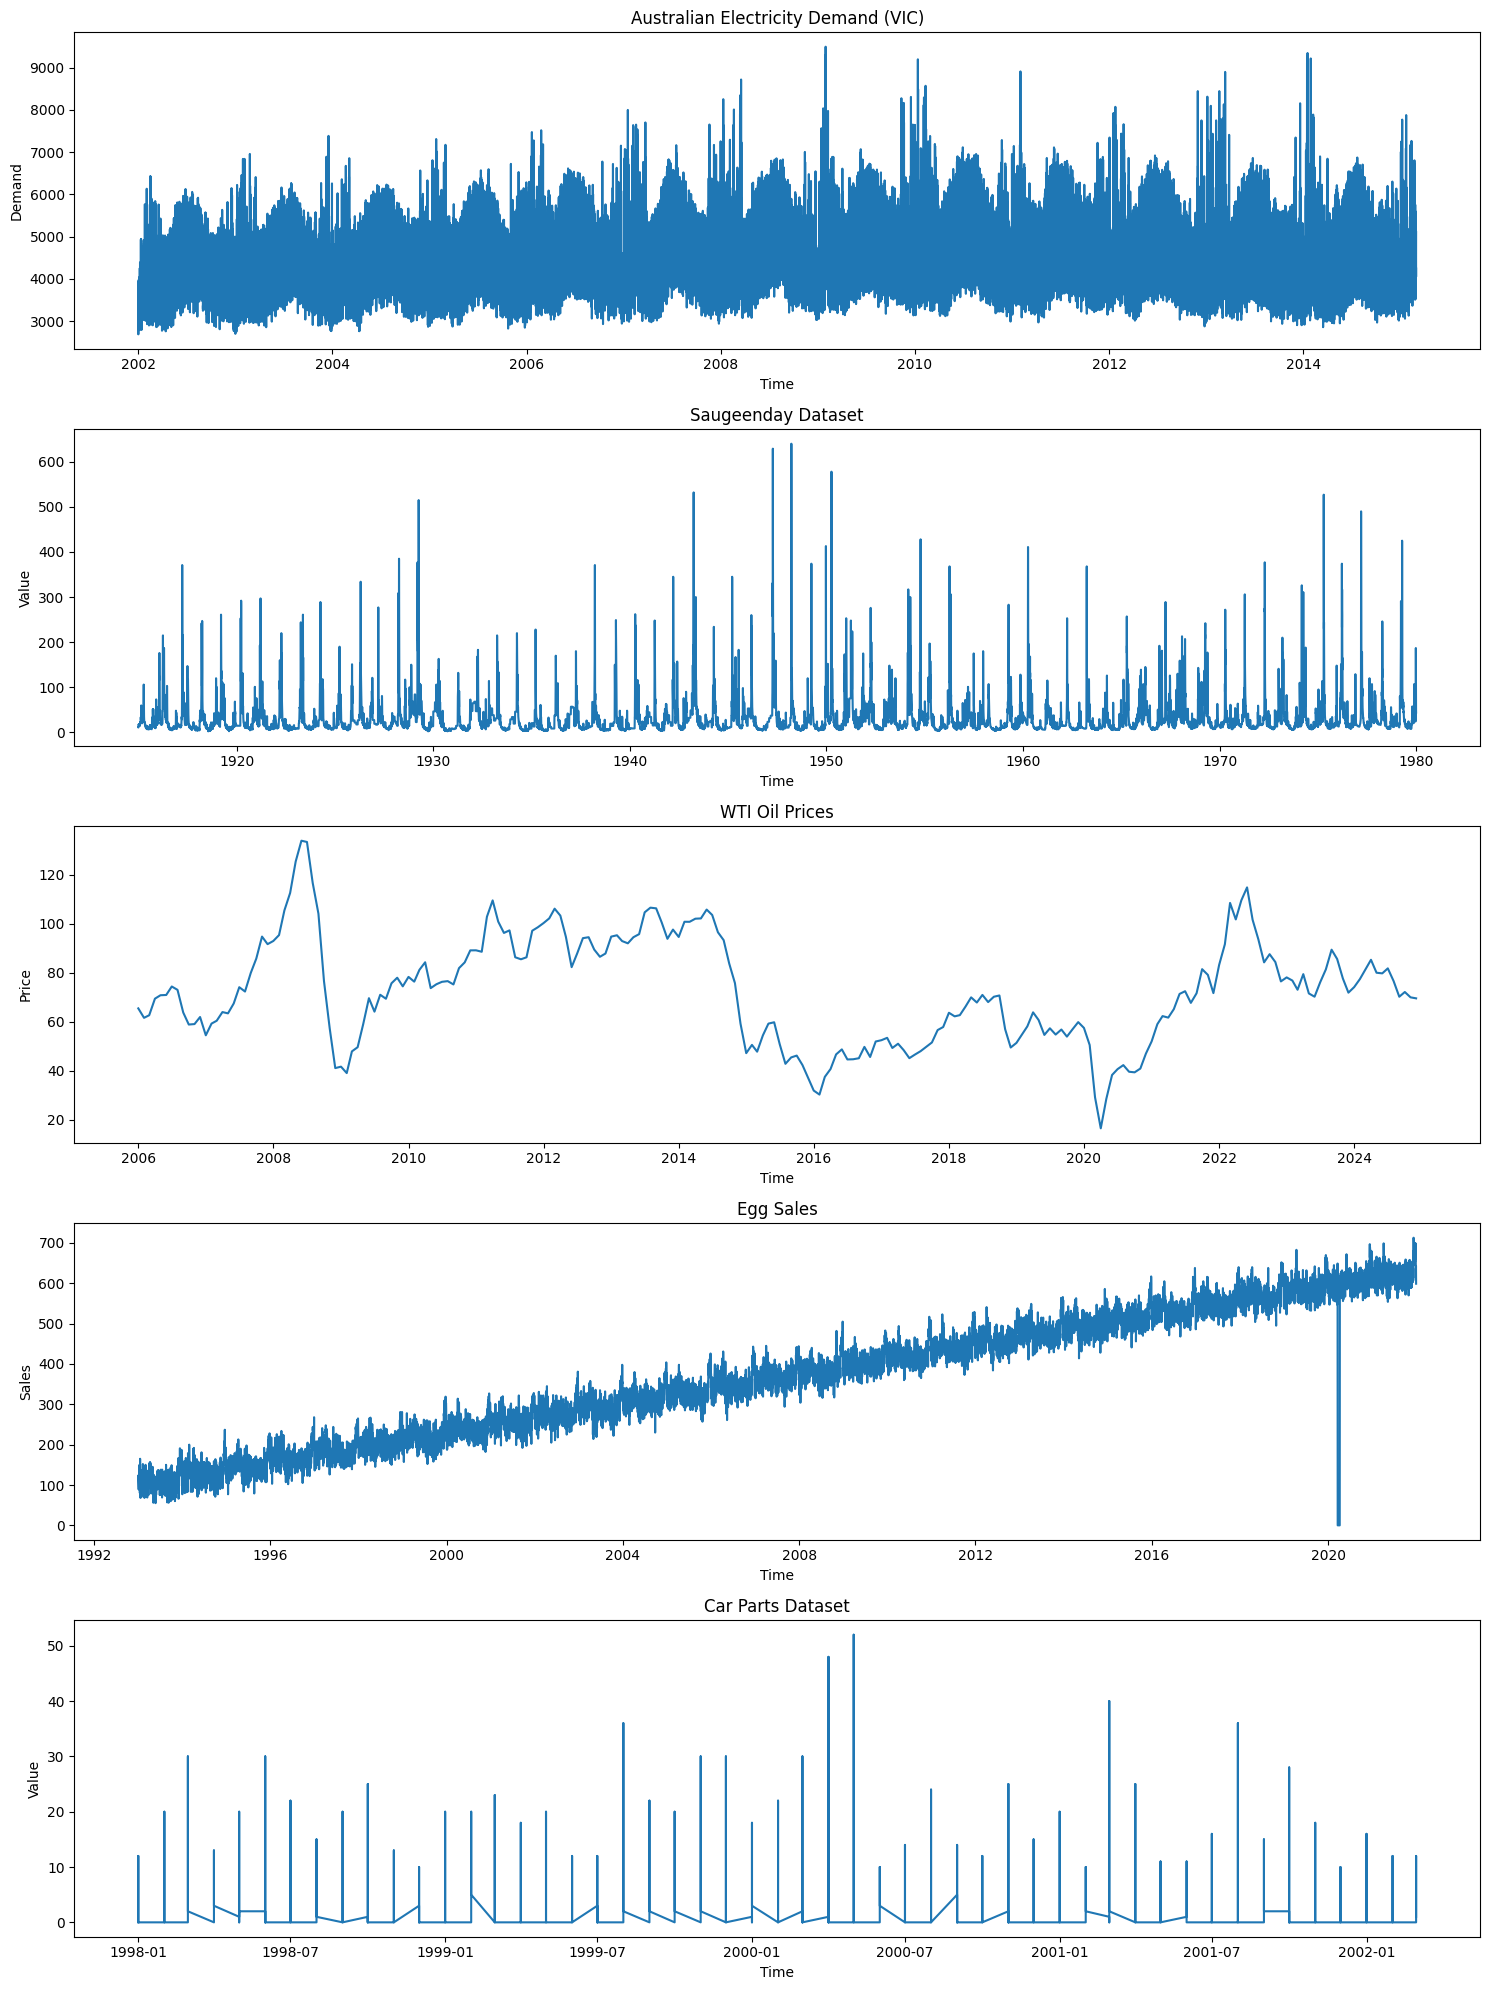

In [1]:
%run "datagetter.ipynb"
%run "basic_functions.ipynb"

12:38:26 - cmdstanpy - INFO - Chain [1] start processing
12:38:26 - cmdstanpy - INFO - Chain [1] done processing


==== WTI Oil ====


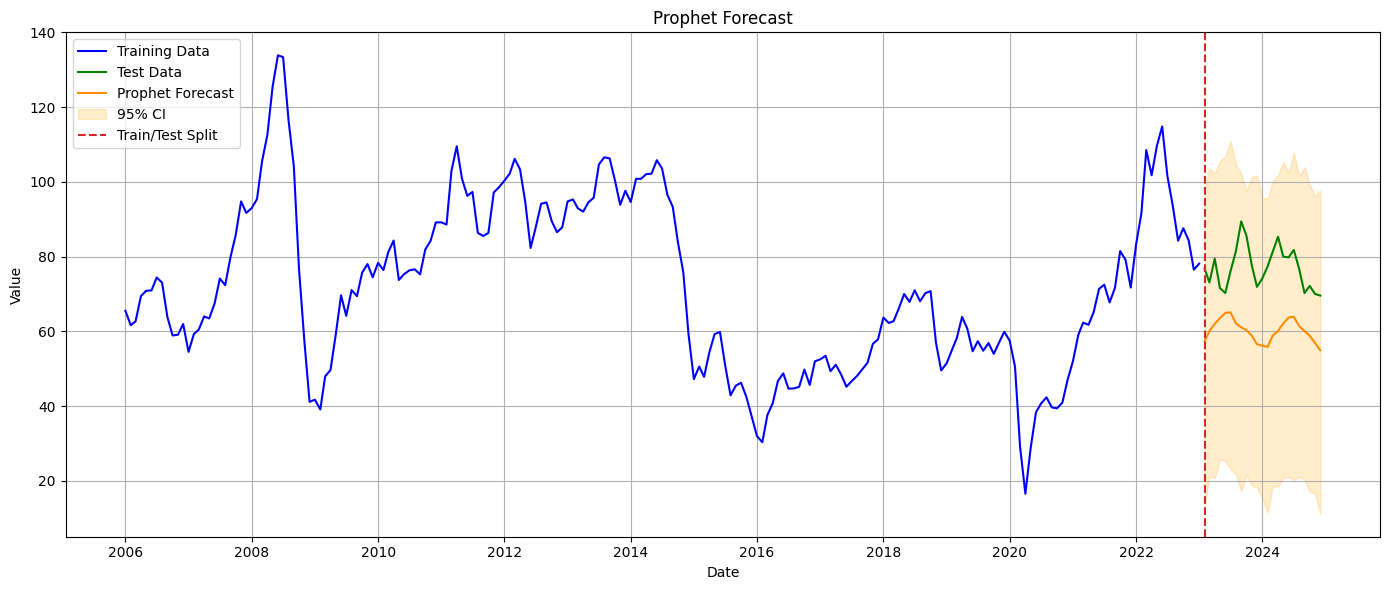

MAE: 16.83
MAPE: 21.54%
RMSE: 17.70
==== Saugeen River ====


12:38:27 - cmdstanpy - INFO - Chain [1] start processing
12:38:34 - cmdstanpy - INFO - Chain [1] done processing


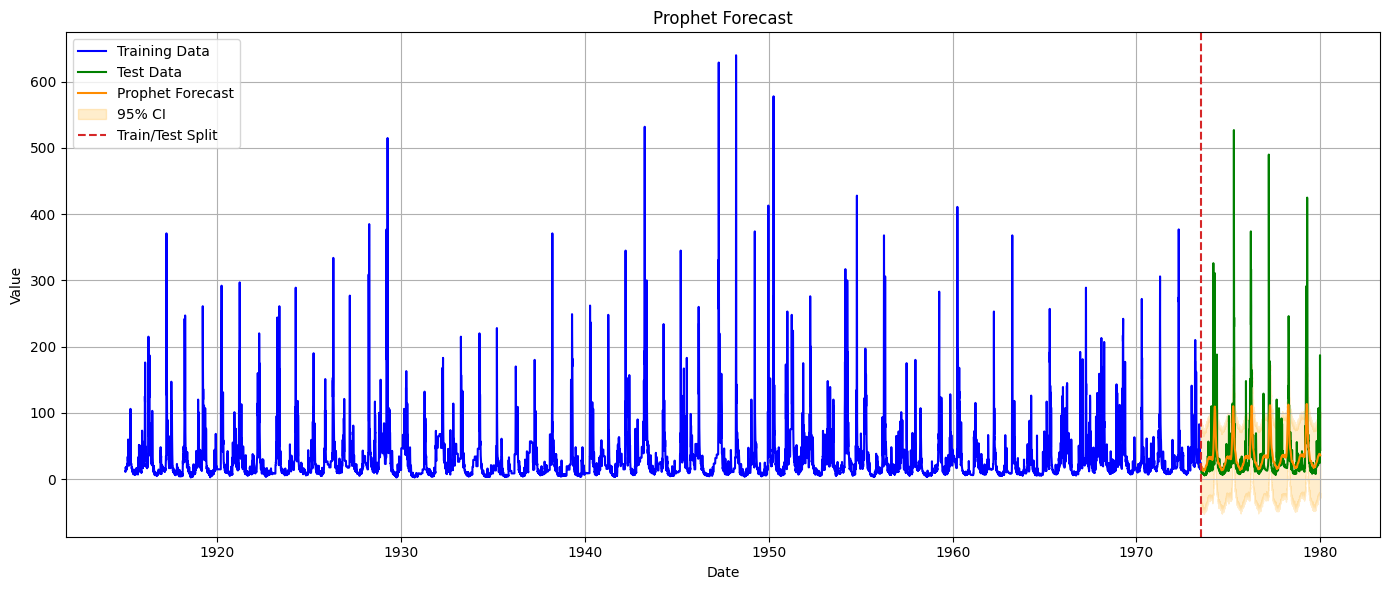

MAE: 19.03
MAPE: 74.47%
RMSE: 36.49
==== Egg Sales ====


12:38:38 - cmdstanpy - INFO - Chain [1] start processing
12:38:38 - cmdstanpy - INFO - Chain [1] done processing


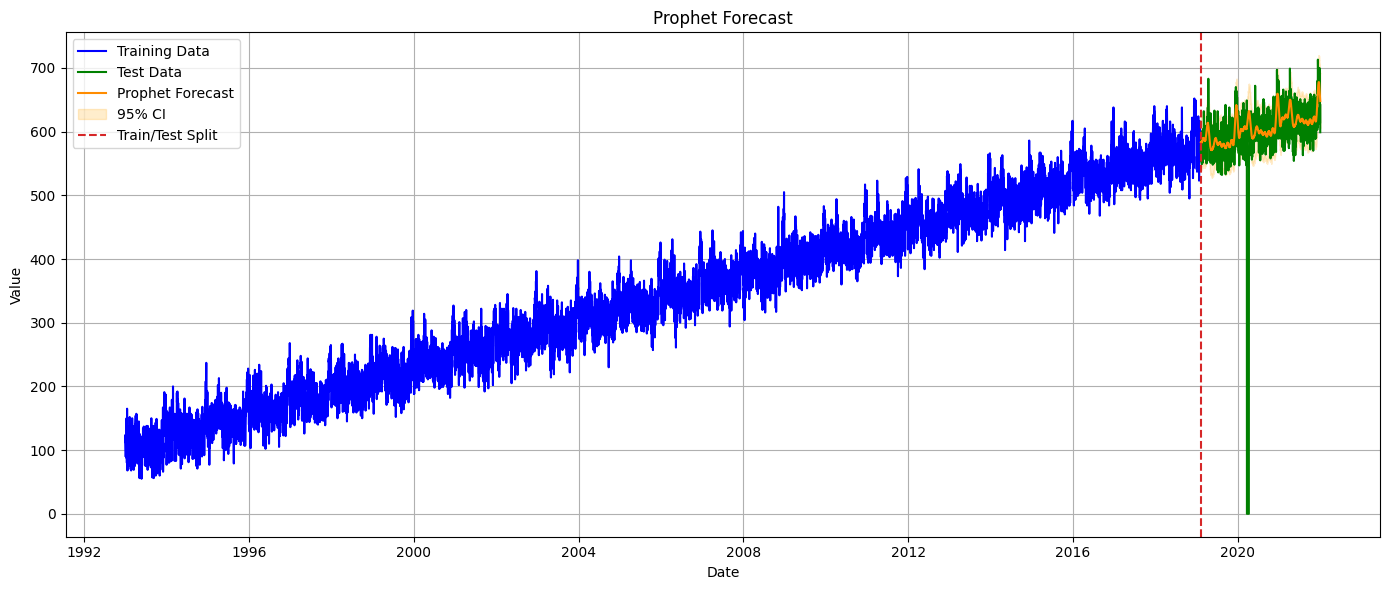

MAE: 27.72
MAPE: 2.90%
RMSE: 83.75
==== Australian Electricity Demand ====


12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:40:34 - cmdstanpy - INFO - Chain [1] done processing


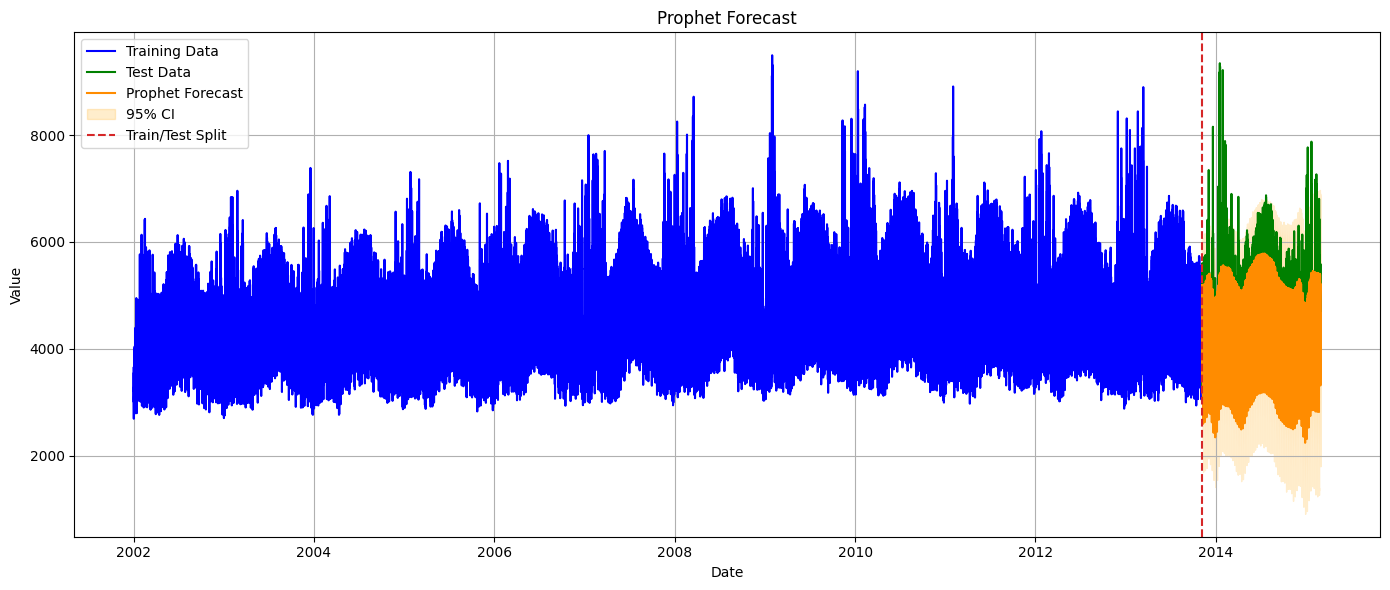

MAE: 382.03
MAPE: 8.12%
RMSE: 554.02
==== Car Parts ====


12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing


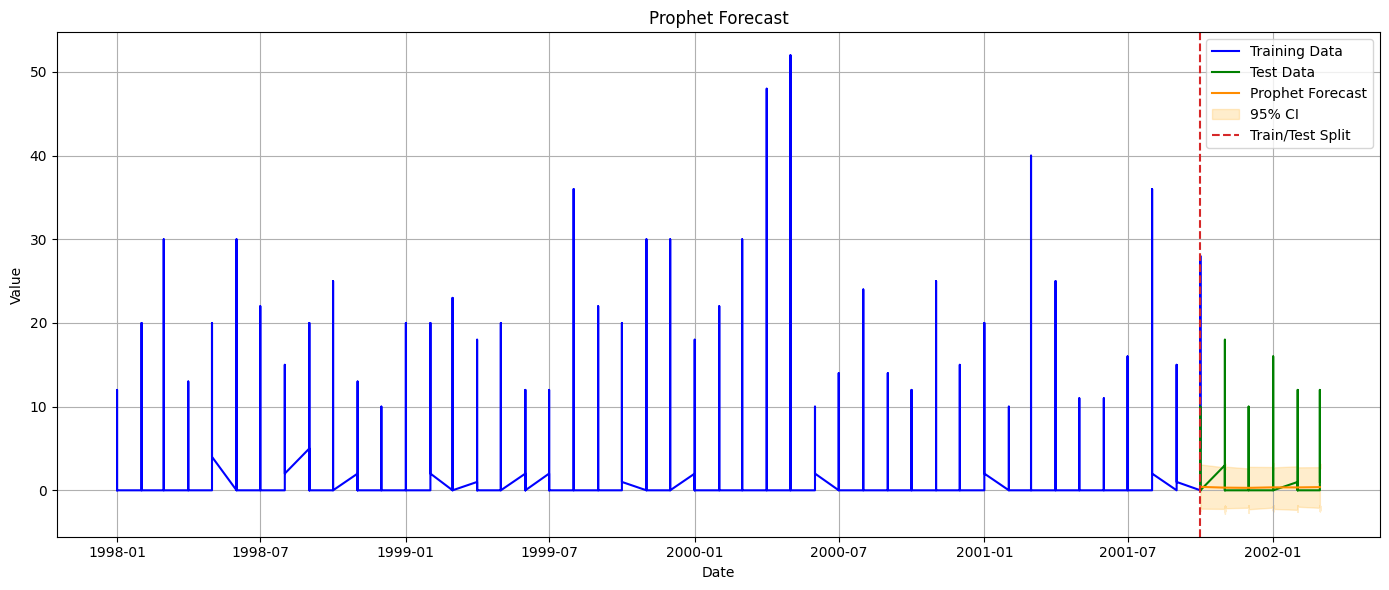

MAE: 0.56
MAPE: 74.37%
RMSE: 0.99


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

def calc_forecast_metrics(y_true, y_pred):
    """Return MAE, MAPE, RMSE in a dictionary for model evaluation."""
    def mape(y_true, y_pred):
     y_true, y_pred = np.array(y_true), np.array(y_pred)
     mask = y_true != 0
     return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    def mae(y_true, y_pred):
        return np.mean(np.abs(y_true - y_pred))
    def rmse(y_true, y_pred):
        return np.sqrt(np.mean((y_true - y_pred) ** 2))
    return {
        "MAE": mae(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred)
    }

def prophet_forecast(train_df, test_df, alpha=0.05, figsize=(14, 6)):
    """
    Fit Prophet model, generate forecasts, plot, and display metrics.
    Returns: model, forecast_test (includes ds, yhat, yhat_lower, yhat_upper)
    """
    # Prophet expects 'ds' (datetime) and 'y' (float) columns
    m = Prophet(interval_width=1-alpha)
    m.fit(train_df)
    future = pd.concat([train_df[['ds']], test_df[['ds']]], ignore_index=True)
    forecast = m.predict(future)
    
    # Only forecast for the test period
    forecast_test = forecast[forecast['ds'].isin(test_df['ds'])].copy()
    forecast_test = forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    test_df_sorted = test_df.sort_values('ds').reset_index(drop=True)
    forecast_test_sorted = forecast_test.sort_values('ds').reset_index(drop=True)

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')
    plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='green')
    plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Prophet Forecast', color='darkorange')
    plt.fill_between(forecast_test['ds'],
                     forecast_test['yhat_lower'],
                     forecast_test['yhat_upper'],
                     color='orange', alpha=0.2, label=f'{int((1-alpha)*100)}% CI')
    split_date = test_df['ds'].iloc[0]
    plt.axvline(split_date, color='tab:red', linestyle='--', label='Train/Test Split')
    plt.title('Prophet Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- METRICS ----
    # Align test and forecast by date
    eval_df = test_df_sorted.merge(forecast_test_sorted[['ds', 'yhat']], on='ds', how='left')
    metrics = calc_forecast_metrics(eval_df['y'].values, eval_df['yhat'].values)
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"MAPE: {metrics['MAPE']:.2f}%")
    print(f"RMSE: {metrics['RMSE']:.2f}")

    return m, forecast_test

# Usage loop remains unchanged:
for name, df in zip(dataset_names, datasets):
    train_df, test_df = split_train_test(df, test_size=0.1)
    print(f"==== {name} ====")
    model, forecast = prophet_forecast(train_df, test_df)
    results[name] = {"model": model, "forecast": forecast}
